# クラス分類学習モデルの作成、予測の実行

In [1]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from seaborn_analyzer import classplot
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

%matplotlib inline

# プログレスバー
from tqdm import tqdm

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# ファイル保存関数（dirがなければ生成する）
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [2]:
df_MB_OS_status_in_5years_dropped = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_DIR
    + "/2.0.4-df_MB_OS_status_in_5years_dropped.pkl"
)
df_MB_OS_status_in_5years_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1123
Data columns (total 56 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   1042 non-null   float64
 1   NPI                                                             1042 non-null   float64
 2   CELLULARITY                                                     1042 non-null   int64  
 3   CHEMOTHERAPY                                                    1042 non-null   bool   
 4   ER_IHC                                                          1042 non-null   int64  
 5   HER2_SNP6                                                       1042 non-null   int64  
 6   HORMONE_THERAPY                                                 1042 non-null   bool   
 7   INFERRED_MENOPAUSAL_STATE                          

In [3]:
print(df_MB_OS_status_in_5years_dropped.target.value_counts())

print(
    "データセット全体に占める5年後の死亡者のデータの割合： ",
    df_MB_OS_status_in_5years_dropped[
        df_MB_OS_status_in_5years_dropped.target == True
    ].shape[0]
    / df_MB_OS_status_in_5years_dropped.shape[0],
)

False    844
True     198
Name: target, dtype: int64
データセット全体に占める5年後の死亡者のデータの割合：  0.19001919385796545


# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [4]:
# Xとyに分割
X = df_MB_OS_status_in_5years_dropped.drop("target", axis=1)
y = df_MB_OS_status_in_5years_dropped["target"]
display(X.tail(), y.tail(), y.value_counts())

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,RADIO_THERAPY,ER_STATUS,HER2_STATUS,GRADE,PR_STATUS,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,COHORT_2.0,COHORT_3.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,INTCLUST_4ER+,INTCLUST_4ER-,...,CLAUDIN_SUBTYPE_Her2,CLAUDIN_SUBTYPE_LumA,CLAUDIN_SUBTYPE_LumB,CLAUDIN_SUBTYPE_NC,CLAUDIN_SUBTYPE_Normal,CLAUDIN_SUBTYPE_claudin-low,THREEGENE_ER+/HER2- Low Prolif,THREEGENE_ER-/HER2-,THREEGENE_HER2+,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,BREAST_SURGERY_MASTECTOMY,LATERALITY_Right,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
1119,4.0,5.060,3,False,1,2,True,1,71.22,False,1,-1,2.0,1,30.0,2.0,14.382695,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
1120,0.0,2.040,3,False,1,2,False,1,70.65,True,1,-1,1.0,1,20.0,1.0,11.767659,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1121,0.0,4.040,3,False,-1,3,False,1,75.62,False,-1,-1,3.0,-1,20.0,1.0,5.230071,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0
1122,6.0,5.040,3,True,1,2,False,1,52.84,True,1,-1,2.0,1,20.0,2.0,6.537589,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
1123,0.0,3.044,3,False,1,2,False,1,63.20,True,1,-1,2.0,1,22.0,2.0,3.922553,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0


1119    False
1120    False
1121    False
1122    False
1123    False
Name: target, dtype: bool

False    844
True     198
Name: target, dtype: int64

In [5]:
# trainとtestに分割

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(781, 55)

(261, 55)

(781,)

(261,)

False    638
True     143
Name: target, dtype: int64

False    206
True      55
Name: target, dtype: int64

# 学習データの分布をプロット

オーバーサンプリング手法がどのように目的変数を生成しているのかを可視化する。  
x,y軸には以下の２パターンを描画する  
1. 3.0.0のノートブックで実施した決定木で重要度の上位に位置した特徴量（["NPI", "THREEGENE_ER-/HER2-"]）
2. float型の特徴量の中で、値がそれなりに分布している特徴量（["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]）

## ツール
- seaborn-analyzer: https://github.com/c60evaporator/seaborn-analyzer

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def transform_normalization(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    ss = StandardScaler()
    ss.fit(df)
    df = pd.DataFrame(
        ss.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df


def transform_minmaxscaler(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    mm = MinMaxScaler()
    mm.fit(df)
    df = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df


# 標準化・正規化の例
"""
df_tmp = transform_normalization(
    pd.merge(X_train, y_train, left_index=True, right_index=True)[plot_columns_1]
)

sns_joinplot(
    pd.merge(df_tmp, y_train, left_index=True, right_index=True),
    plot_columns=plot_columns_1,
)

df_tmp = transform_minmaxscaler(
    pd.merge(X_train, y_train, left_index=True, right_index=True)
)
sns_joinplot(
    pd.merge(df_tmp[plot_columns_2], y_train, left_index=True, right_index=True),
    plot_columns=plot_columns_2,
)
"""
pass

plotするための関数

In [7]:
plot_columns_1 = ["NPI", "THREEGENE_ER-/HER2-"]  # 3.0.0の決定木モデルで最も重要度の高かった特徴量
plot_columns_2 = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]  # 適当な量的変数の特徴量
plot_columns_3 = ["TUMOR_SIZE", "LYMPH_NODES_EXAMINED_POSITIVE"]  # targetと相関の高い特徴量

In [8]:
def sns_joinplot(
    data: pd.DataFrame,
    plot_columns: list,
    target: str = "target",
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data
    if normalization:
        df_tmp = transform_minmaxscaler(df_tmp)
    sns.jointplot(
        x=plot_columns[0],
        y=plot_columns[1],
        data=df_tmp,
        hue=target,
    )
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

cv_number=0/10


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


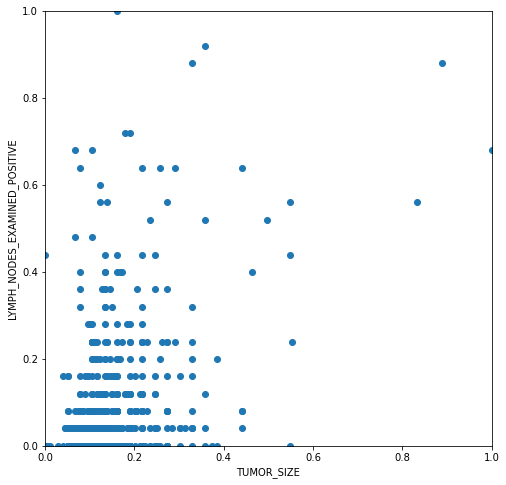

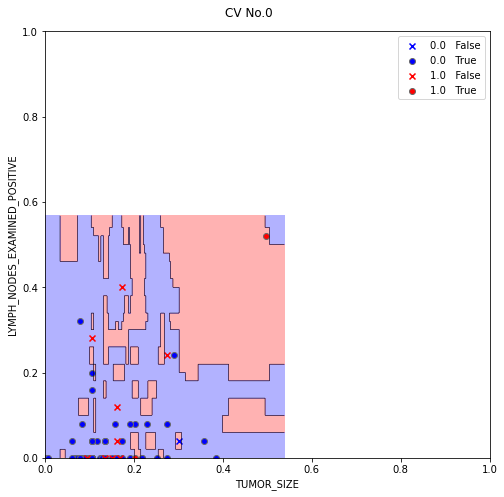

In [9]:
# プロットの共通化のために関数を定義。パラメータの固定が目的
# 範囲は基本[0,1]とし、プロットした際に比較しやすいようにする。
def sns_separator_plot(
    clf,
    x_columns: list,
    y_column: str,
    data: pd.DataFrame,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data
    if normalization:
        df_tmp = transform_minmaxscaler(data)
    # display(df_tmp[x_columns])
    # 散布図のプロット
    plt.figure(figsize=(8, 8))
    plt.scatter(df_tmp[x_columns[0]], df_tmp[x_columns[1]])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel(x_columns[0])
    plt.ylabel(x_columns[1])
    plt.plot()

    classplot.class_separator_plot(
        clf=clf,
        x=x_columns,
        y=y_column,
        data=df_tmp,
        # plot_scatter="class_error",
        scatter_colors=["r", "b"],
        cv=10,
        cv_seed=SEED,
        true_marker="o",
        false_marker="x",
        subplot_kws={"figsize": (7, 7)},
    )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save_path:
        plt.savefig(save_path)
    else:
        plt.plot()


# 例

df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

clf = RandomForestClassifier()
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns_3,
    y_column="target",
    data=df_tmp,
)

pass

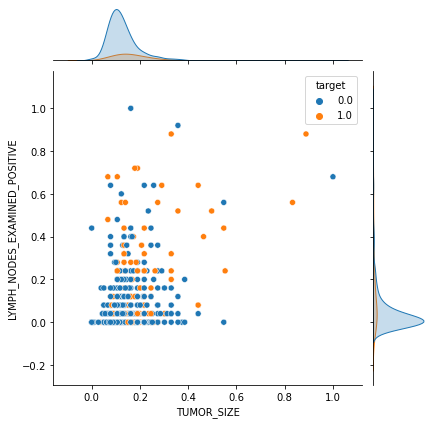

In [10]:
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

save_path = (
    config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/basic_scatter("
    + plot_columns_3[0]
    + " x "
    + plot_columns_3[1]
    + ").jpeg"
)

# plot_columns_3の散布図
sns_joinplot(df_tmp, plot_columns_3, save_path=save_path)

cv_number=0/10


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


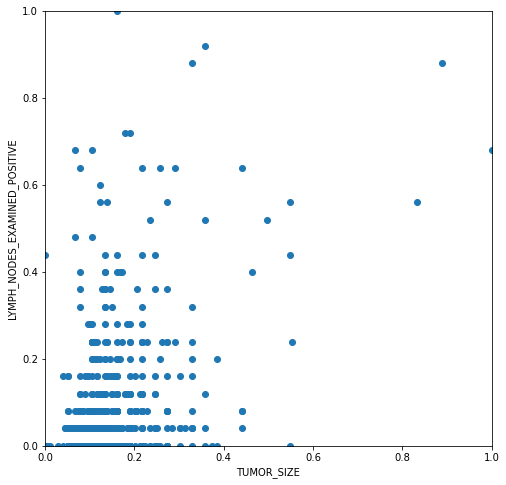

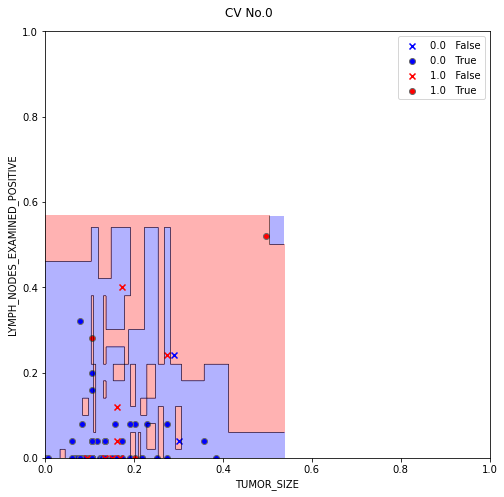

In [11]:
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

clf = DecisionTreeClassifier()
# plot_columns_1での分類図例
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns_3,
    y_column="target",
    data=df_tmp,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/sample_normal_pc3.png",
)

# SMOTEによるオーバーサンプリング
SMOTEと呼ばれる手法によって、不均衡を低減する  
どのようにオーバーサンプリングするのか要確認

In [12]:
sm = SMOTE(random_state=SEED)

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled.value_counts()

True     638
False    638
Name: target, dtype: int64

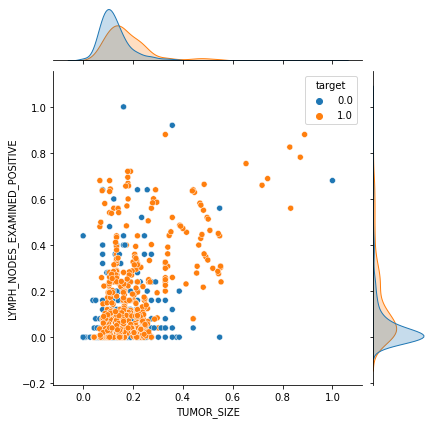

In [13]:
df_tmp = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)

save_path = (
    config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR
    + "/SMOTE_scatter("
    + plot_columns_3[0]
    + " x "
    + plot_columns_3[1]
    + ").jpeg"
)

sns_joinplot(data=df_tmp, plot_columns=plot_columns_3, save_path=save_path)

cv_number=0/10


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


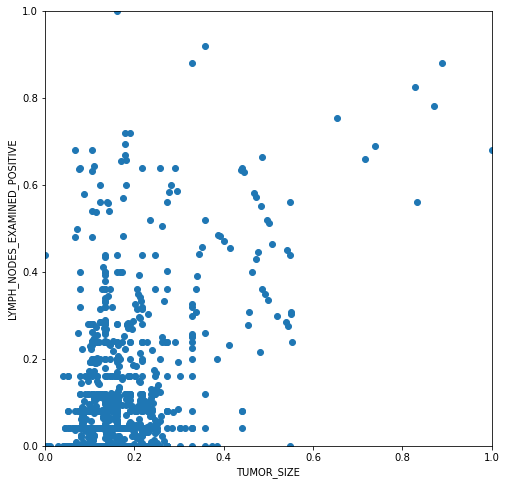

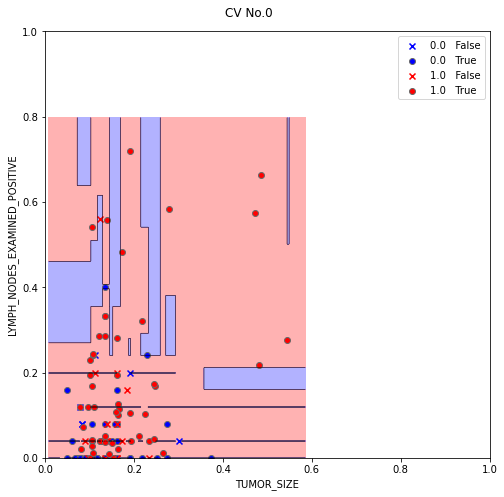

In [14]:
clf = DecisionTreeClassifier()
# 例
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns_3,
    y_column="target",
    data=df_tmp,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/sample_SMOTE_pc3.png",
)

# 2値分類モデル

In [15]:
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [16]:
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    206
True      55
Name: target, dtype: int64

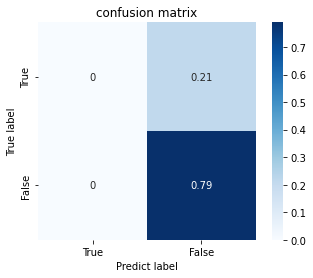

In [17]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

## オーバーサンプリング手法の比較

オーバーサンプリング手法を比較する。  
モデルはデフォルトのものを用い、今回のデータセットに適した・あるいは特徴的なオーバーサンプリングがないか探す。  

### オーバーサンプリングライブラリ
1. imblearn(https://imbalanced-learn.org/stable/over_sampling.html)


In [18]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

In [19]:
import warnings


def compare_bcms(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    sort_column_name: str = "f1_test",
    average_time: int = 20,
    test_size: float = 0.25,
    over_sampling=None,
    plot_columns: list = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"],
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    # for _ in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
    for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
        # 乱数の影響を均した平均を取りたいので、SEEDは保留。乱数に依存しない精度を見るので再現性は'ここでは'担保しない。
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
        )  # 訓練データ・テストデータの生成
        if over_sampling:
            X_train, y_train = sm.fit_resample(X_train, y_train)

        # for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
        for _ in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
            print(name)  # モデル名
            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納
    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_22643/679312547.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


数回実行し、再現性がないことと、各モデルが頑健かの確認

In [20]:
compare_bcms(
    X=X,
    y=y,
    average_time=100,
    over_sampling=SMOTE(),
    plot_columns=["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"],
)

  3%|████████▏                                                                                                                                                                                                                                                                         | 3/100 [00:00<00:03, 27.08it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


  9%|████████████████████████▋                                                                                                                                                                                                                                                         | 9/100 [00:00<00:03, 26.19it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                     | 16/100 [00:00<00:03, 27.83it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 22/100 [00:00<00:02, 28.47it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 29/100 [00:01<00:02, 26.26it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 33%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 33/100 [00:01<00:02, 28.53it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 39/100 [00:01<00:02, 26.60it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 46/100 [00:01<00:02, 26.59it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 53/100 [00:01<00:01, 28.21it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 61/100 [00:02<00:01, 32.10it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 69/100 [00:02<00:01, 29.66it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 73/100 [00:02<00:00, 29.03it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 79/100 [00:02<00:00, 23.27it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 88/100 [00:03<00:00, 30.66it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 97/100 [00:03<00:00, 35.17it/s]

Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression
Logistic Regression


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.07it/s]


Logistic Regression
Logistic Regression


  4%|██████████▉                                                                                                                                                                                                                                                                       | 4/100 [00:00<00:02, 39.40it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 12%|████████████████████████████████▊                                                                                                                                                                                                                                                | 12/100 [00:00<00:02, 39.32it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 22/100 [00:00<00:01, 40.01it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 31/100 [00:00<00:01, 39.70it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 36/100 [00:00<00:01, 40.00it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 41/100 [00:01<00:01, 40.34it/s]

Nearest Neighbors
Nearest Neighbors


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 46/100 [00:01<00:01, 40.31it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 51/100 [00:01<00:01, 40.27it/s]

Nearest Neighbors
Nearest Neighbors


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 56/100 [00:01<00:01, 40.43it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 66/100 [00:01<00:00, 40.27it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 76/100 [00:01<00:00, 40.40it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 81/100 [00:02<00:00, 40.40it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 86/100 [00:02<00:00, 39.56it/s]

Nearest Neighbors
Nearest Neighbors


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 91/100 [00:02<00:00, 39.83it/s]

Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 95/100 [00:02<00:00, 39.87it/s]

Nearest Neighbors
Nearest Neighbors


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.95it/s]


Nearest Neighbors
Nearest Neighbors
Nearest Neighbors
Nearest Neighbors


  0%|                                                                                                                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

Linear SVM


  1%|██▋                                                                                                                                                                                                                                                                               | 1/100 [00:00<00:29,  3.34it/s]

Linear SVM


  2%|█████▍                                                                                                                                                                                                                                                                            | 2/100 [00:00<00:28,  3.39it/s]

Linear SVM


  3%|████████▏                                                                                                                                                                                                                                                                         | 3/100 [00:00<00:28,  3.37it/s]

Linear SVM


  4%|██████████▉                                                                                                                                                                                                                                                                       | 4/100 [00:01<00:28,  3.38it/s]

Linear SVM


  5%|█████████████▋                                                                                                                                                                                                                                                                    | 5/100 [00:01<00:27,  3.40it/s]

Linear SVM


  6%|████████████████▍                                                                                                                                                                                                                                                                 | 6/100 [00:01<00:27,  3.41it/s]

Linear SVM


  7%|███████████████████▏                                                                                                                                                                                                                                                              | 7/100 [00:02<00:27,  3.42it/s]

Linear SVM


  8%|█████████████████████▉                                                                                                                                                                                                                                                            | 8/100 [00:02<00:26,  3.42it/s]

Linear SVM


  9%|████████████████████████▋                                                                                                                                                                                                                                                         | 9/100 [00:02<00:26,  3.40it/s]

Linear SVM


 10%|███████████████████████████▎                                                                                                                                                                                                                                                     | 10/100 [00:02<00:26,  3.40it/s]

Linear SVM


 11%|██████████████████████████████                                                                                                                                                                                                                                                   | 11/100 [00:03<00:26,  3.37it/s]

Linear SVM


 12%|████████████████████████████████▊                                                                                                                                                                                                                                                | 12/100 [00:03<00:26,  3.37it/s]

Linear SVM


 13%|███████████████████████████████████▍                                                                                                                                                                                                                                             | 13/100 [00:03<00:25,  3.37it/s]

Linear SVM


 14%|██████████████████████████████████████▏                                                                                                                                                                                                                                          | 14/100 [00:04<00:25,  3.37it/s]

Linear SVM


 15%|████████████████████████████████████████▉                                                                                                                                                                                                                                        | 15/100 [00:04<00:25,  3.38it/s]

Linear SVM


 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                     | 16/100 [00:04<00:24,  3.40it/s]

Linear SVM


 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 17/100 [00:05<00:24,  3.41it/s]

Linear SVM


 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 18/100 [00:05<00:24,  3.42it/s]

Linear SVM


 19%|███████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 19/100 [00:05<00:23,  3.42it/s]

Linear SVM


 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 20/100 [00:05<00:23,  3.43it/s]

Linear SVM


 21%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                       | 21/100 [00:06<00:22,  3.44it/s]

Linear SVM


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 22/100 [00:06<00:22,  3.44it/s]

Linear SVM


 23%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 23/100 [00:06<00:22,  3.44it/s]

Linear SVM


 24%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                               | 24/100 [00:07<00:22,  3.45it/s]

Linear SVM


 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 25/100 [00:07<00:21,  3.45it/s]

Linear SVM


 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 26/100 [00:07<00:21,  3.46it/s]

Linear SVM


 27%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 27/100 [00:07<00:21,  3.47it/s]

Linear SVM


 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 28/100 [00:08<00:20,  3.48it/s]

Linear SVM


 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 29/100 [00:08<00:20,  3.49it/s]

Linear SVM


 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 30/100 [00:08<00:20,  3.49it/s]

Linear SVM


 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 31/100 [00:09<00:19,  3.49it/s]

Linear SVM


 32%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 32/100 [00:09<00:19,  3.49it/s]

Linear SVM


 33%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 33/100 [00:09<00:19,  3.49it/s]

Linear SVM


 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 34/100 [00:09<00:18,  3.50it/s]

Linear SVM


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 35/100 [00:10<00:18,  3.50it/s]

Linear SVM


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 36/100 [00:10<00:18,  3.50it/s]

Linear SVM


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 37/100 [00:10<00:18,  3.50it/s]

Linear SVM


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 38/100 [00:11<00:17,  3.50it/s]

Linear SVM


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 39/100 [00:11<00:17,  3.49it/s]

Linear SVM


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 40/100 [00:11<00:17,  3.49it/s]

Linear SVM


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 41/100 [00:11<00:16,  3.49it/s]

Linear SVM


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 42/100 [00:12<00:16,  3.49it/s]

Linear SVM


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 43/100 [00:12<00:16,  3.50it/s]

Linear SVM


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 44/100 [00:12<00:16,  3.50it/s]

Linear SVM


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 45/100 [00:13<00:15,  3.49it/s]

Linear SVM


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 46/100 [00:13<00:15,  3.49it/s]

Linear SVM


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 47/100 [00:13<00:15,  3.49it/s]

Linear SVM


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 48/100 [00:13<00:14,  3.49it/s]

Linear SVM


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 49/100 [00:14<00:14,  3.49it/s]

Linear SVM


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 50/100 [00:14<00:14,  3.47it/s]

Linear SVM


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 51/100 [00:14<00:14,  3.48it/s]

Linear SVM


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 52/100 [00:15<00:13,  3.48it/s]

Linear SVM


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 53/100 [00:15<00:13,  3.47it/s]

Linear SVM


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 54/100 [00:15<00:13,  3.46it/s]

Linear SVM


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 55/100 [00:15<00:13,  3.46it/s]

Linear SVM


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 56/100 [00:16<00:12,  3.46it/s]

Linear SVM


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 57/100 [00:16<00:12,  3.47it/s]

Linear SVM


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 58/100 [00:16<00:12,  3.48it/s]

Linear SVM


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 59/100 [00:17<00:11,  3.47it/s]

Linear SVM


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 60/100 [00:17<00:11,  3.47it/s]

Linear SVM


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 61/100 [00:17<00:11,  3.48it/s]

Linear SVM


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 62/100 [00:17<00:10,  3.46it/s]

Linear SVM


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 63/100 [00:18<00:10,  3.46it/s]

Linear SVM


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 64/100 [00:18<00:10,  3.47it/s]

Linear SVM


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 65/100 [00:18<00:10,  3.48it/s]

Linear SVM


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 66/100 [00:19<00:09,  3.47it/s]

Linear SVM


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 67/100 [00:19<00:09,  3.47it/s]

Linear SVM


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 68/100 [00:19<00:09,  3.46it/s]

Linear SVM


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 69/100 [00:19<00:08,  3.46it/s]

Linear SVM


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 70/100 [00:20<00:08,  3.45it/s]

Linear SVM


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 71/100 [00:20<00:08,  3.45it/s]

Linear SVM


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 72/100 [00:20<00:08,  3.45it/s]

Linear SVM


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 73/100 [00:21<00:07,  3.45it/s]

Linear SVM


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 74/100 [00:21<00:07,  3.46it/s]

Linear SVM


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 75/100 [00:21<00:07,  3.46it/s]

Linear SVM


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 76/100 [00:21<00:06,  3.47it/s]

Linear SVM


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 77/100 [00:22<00:06,  3.47it/s]

Linear SVM


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 78/100 [00:22<00:06,  3.48it/s]

Linear SVM


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 79/100 [00:22<00:06,  3.48it/s]

Linear SVM


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 80/100 [00:23<00:05,  3.43it/s]

Linear SVM


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 81/100 [00:23<00:05,  3.45it/s]

Linear SVM


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 82/100 [00:23<00:05,  3.45it/s]

Linear SVM


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 83/100 [00:24<00:04,  3.46it/s]

Linear SVM


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 84/100 [00:24<00:04,  3.47it/s]

Linear SVM


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 85/100 [00:24<00:04,  3.47it/s]

Linear SVM


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 86/100 [00:24<00:04,  3.48it/s]

Linear SVM


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 87/100 [00:25<00:03,  3.47it/s]

Linear SVM


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 88/100 [00:25<00:03,  3.43it/s]

Linear SVM


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 89/100 [00:25<00:03,  3.41it/s]

Linear SVM


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 90/100 [00:26<00:02,  3.43it/s]

Linear SVM


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 91/100 [00:26<00:02,  3.45it/s]

Linear SVM


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 92/100 [00:26<00:02,  3.45it/s]

Linear SVM


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 93/100 [00:26<00:02,  3.41it/s]

Linear SVM


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 94/100 [00:27<00:01,  3.39it/s]

Linear SVM


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 95/100 [00:27<00:01,  3.39it/s]

Linear SVM


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 96/100 [00:27<00:01,  3.38it/s]

Linear SVM


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 97/100 [00:28<00:00,  3.39it/s]

Linear SVM


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 98/100 [00:28<00:00,  3.41it/s]

Linear SVM


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 99/100 [00:28<00:00,  3.40it/s]

Linear SVM


  1%|██▋                                                                                                                                                                                                                                                                               | 1/100 [00:00<00:10,  9.49it/s]

Polynomial SVM
Polynomial SVM


  3%|████████▏                                                                                                                                                                                                                                                                         | 3/100 [00:00<00:09,  9.73it/s]

Polynomial SVM
Polynomial SVM


  6%|████████████████▍                                                                                                                                                                                                                                                                 | 6/100 [00:00<00:09,  9.88it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


  8%|█████████████████████▉                                                                                                                                                                                                                                                            | 8/100 [00:00<00:09,  9.87it/s]

Polynomial SVM
Polynomial SVM


 11%|██████████████████████████████                                                                                                                                                                                                                                                   | 11/100 [00:01<00:09,  9.88it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 13%|███████████████████████████████████▍                                                                                                                                                                                                                                             | 13/100 [00:01<00:08,  9.91it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 17/100 [00:01<00:08, 10.07it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 19%|███████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 19/100 [00:01<00:08, 10.05it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 23%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 23/100 [00:02<00:07, 10.11it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 25/100 [00:02<00:07,  9.72it/s]

Polynomial SVM
Polynomial SVM


 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 28/100 [00:02<00:07,  9.85it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 30/100 [00:03<00:07,  9.96it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 34/100 [00:03<00:06, 10.01it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 36/100 [00:03<00:06,  9.99it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 40/100 [00:04<00:05, 10.02it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 42/100 [00:04<00:05,  9.80it/s]

Polynomial SVM
Polynomial SVM


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 44/100 [00:04<00:05,  9.78it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 48/100 [00:04<00:05,  9.94it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 50/100 [00:05<00:05,  9.62it/s]

Polynomial SVM
Polynomial SVM


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 52/100 [00:05<00:05,  9.04it/s]

Polynomial SVM
Polynomial SVM


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 55/100 [00:05<00:04,  9.55it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 57/100 [00:05<00:04,  9.81it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 61/100 [00:06<00:03, 10.04it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 63/100 [00:06<00:03, 10.07it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 67/100 [00:06<00:03, 10.15it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 69/100 [00:06<00:03, 10.12it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 73/100 [00:07<00:02, 10.13it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 75/100 [00:07<00:02, 10.13it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 77/100 [00:07<00:02, 10.06it/s]

Polynomial SVM
Polynomial SVM


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 81/100 [00:08<00:01,  9.93it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 83/100 [00:08<00:01,  9.99it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 85/100 [00:08<00:01, 10.05it/s]

Polynomial SVM
Polynomial SVM


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 89/100 [00:08<00:01,  9.98it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 91/100 [00:09<00:00, 10.02it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 95/100 [00:09<00:00, 10.13it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 97/100 [00:09<00:00, 10.14it/s]

Polynomial SVM
Polynomial SVM
Polynomial SVM


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.93it/s]


Polynomial SVM


  0%|                                                                                                                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

RBF SVM


  2%|█████▍                                                                                                                                                                                                                                                                            | 2/100 [00:00<00:19,  4.94it/s]

RBF SVM
RBF SVM


  3%|████████▏                                                                                                                                                                                                                                                                         | 3/100 [00:00<00:19,  5.04it/s]

RBF SVM


  5%|█████████████▋                                                                                                                                                                                                                                                                    | 5/100 [00:01<00:19,  4.96it/s]

RBF SVM
RBF SVM


  7%|███████████████████▏                                                                                                                                                                                                                                                              | 7/100 [00:01<00:18,  5.01it/s]

RBF SVM
RBF SVM


  9%|████████████████████████▋                                                                                                                                                                                                                                                         | 9/100 [00:01<00:18,  5.05it/s]

RBF SVM
RBF SVM


 11%|██████████████████████████████                                                                                                                                                                                                                                                   | 11/100 [00:02<00:17,  5.05it/s]

RBF SVM
RBF SVM


 13%|███████████████████████████████████▍                                                                                                                                                                                                                                             | 13/100 [00:02<00:17,  5.02it/s]

RBF SVM
RBF SVM


 15%|████████████████████████████████████████▉                                                                                                                                                                                                                                        | 15/100 [00:02<00:16,  5.08it/s]

RBF SVM
RBF SVM


 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 17/100 [00:03<00:16,  4.95it/s]

RBF SVM
RBF SVM


 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 18/100 [00:03<00:16,  4.84it/s]

RBF SVM


 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 20/100 [00:04<00:16,  4.83it/s]

RBF SVM
RBF SVM


 21%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                       | 21/100 [00:04<00:16,  4.87it/s]

RBF SVM


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 22/100 [00:04<00:16,  4.79it/s]

RBF SVM


 23%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 23/100 [00:04<00:15,  4.81it/s]

RBF SVM


 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 25/100 [00:05<00:15,  4.83it/s]

RBF SVM
RBF SVM


 27%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 27/100 [00:05<00:14,  4.97it/s]

RBF SVM
RBF SVM


 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 28/100 [00:05<00:14,  4.85it/s]

RBF SVM


 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 29/100 [00:05<00:14,  4.77it/s]

RBF SVM


 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 30/100 [00:06<00:14,  4.71it/s]

RBF SVM


 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 31/100 [00:06<00:14,  4.76it/s]

RBF SVM


 32%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 32/100 [00:06<00:14,  4.71it/s]

RBF SVM


 33%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 33/100 [00:06<00:14,  4.77it/s]

RBF SVM


 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 34/100 [00:06<00:13,  4.74it/s]

RBF SVM


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 35/100 [00:07<00:13,  4.73it/s]

RBF SVM


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 37/100 [00:07<00:13,  4.78it/s]

RBF SVM
RBF SVM


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 38/100 [00:07<00:12,  4.84it/s]

RBF SVM


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 40/100 [00:08<00:12,  4.87it/s]

RBF SVM
RBF SVM


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 41/100 [00:08<00:12,  4.90it/s]

RBF SVM


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 43/100 [00:08<00:11,  4.92it/s]

RBF SVM
RBF SVM


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 45/100 [00:09<00:11,  4.99it/s]

RBF SVM
RBF SVM


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 47/100 [00:09<00:10,  5.01it/s]

RBF SVM
RBF SVM


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 49/100 [00:10<00:10,  4.96it/s]

RBF SVM
RBF SVM


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 50/100 [00:10<00:10,  4.84it/s]

RBF SVM


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 51/100 [00:10<00:10,  4.77it/s]

RBF SVM


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 52/100 [00:10<00:10,  4.77it/s]

RBF SVM


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 54/100 [00:11<00:09,  4.79it/s]

RBF SVM
RBF SVM


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 55/100 [00:11<00:09,  4.84it/s]

RBF SVM


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 56/100 [00:11<00:09,  4.77it/s]

RBF SVM


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 58/100 [00:11<00:08,  4.79it/s]

RBF SVM
RBF SVM


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 59/100 [00:12<00:08,  4.89it/s]

RBF SVM


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 60/100 [00:12<00:08,  4.80it/s]

RBF SVM


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 61/100 [00:12<00:08,  4.75it/s]

RBF SVM


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 62/100 [00:12<00:08,  4.71it/s]

RBF SVM


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 64/100 [00:13<00:07,  4.78it/s]

RBF SVM
RBF SVM


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 65/100 [00:13<00:07,  4.74it/s]

RBF SVM


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 67/100 [00:13<00:06,  4.85it/s]

RBF SVM
RBF SVM


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 69/100 [00:14<00:06,  4.83it/s]

RBF SVM
RBF SVM


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 70/100 [00:14<00:06,  4.90it/s]

RBF SVM


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 71/100 [00:14<00:05,  4.88it/s]

RBF SVM


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 73/100 [00:15<00:05,  4.93it/s]

RBF SVM
RBF SVM


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 74/100 [00:15<00:05,  4.88it/s]

RBF SVM


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 75/100 [00:15<00:05,  4.79it/s]

RBF SVM


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 76/100 [00:15<00:05,  4.72it/s]

RBF SVM


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 77/100 [00:15<00:04,  4.70it/s]

RBF SVM


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 78/100 [00:16<00:04,  4.70it/s]

RBF SVM


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 80/100 [00:16<00:04,  4.76it/s]

RBF SVM
RBF SVM


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 81/100 [00:16<00:03,  4.81it/s]

RBF SVM


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 83/100 [00:17<00:03,  4.86it/s]

RBF SVM
RBF SVM


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 85/100 [00:17<00:03,  4.86it/s]

RBF SVM
RBF SVM


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 86/100 [00:17<00:02,  4.90it/s]

RBF SVM


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 88/100 [00:18<00:02,  4.92it/s]

RBF SVM


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 89/100 [00:18<00:02,  4.94it/s]

RBF SVM
RBF SVM


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 90/100 [00:18<00:02,  4.83it/s]

RBF SVM


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 91/100 [00:18<00:01,  4.85it/s]

RBF SVM


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 93/100 [00:19<00:01,  4.85it/s]

RBF SVM
RBF SVM


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 94/100 [00:19<00:01,  4.90it/s]

RBF SVM


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 96/100 [00:19<00:00,  4.90it/s]

RBF SVM
RBF SVM


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 98/100 [00:20<00:00,  4.94it/s]

RBF SVM
RBF SVM


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 99/100 [00:20<00:00,  4.83it/s]

RBF SVM


  2%|█████▍                                                                                                                                                                                                                                                                            | 2/100 [00:00<00:08, 11.06it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


  4%|██████████▉                                                                                                                                                                                                                                                                       | 4/100 [00:00<00:08, 11.27it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


  8%|█████████████████████▉                                                                                                                                                                                                                                                            | 8/100 [00:00<00:08, 11.10it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 10%|███████████████████████████▎                                                                                                                                                                                                                                                     | 10/100 [00:00<00:08, 11.24it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 14%|██████████████████████████████████████▏                                                                                                                                                                                                                                          | 14/100 [00:01<00:07, 11.35it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                     | 16/100 [00:01<00:07, 11.40it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 20/100 [00:01<00:06, 11.47it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 22/100 [00:01<00:06, 11.49it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 26/100 [00:02<00:06, 11.51it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 28/100 [00:02<00:06, 11.51it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 32%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 32/100 [00:02<00:05, 11.53it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 34/100 [00:02<00:05, 11.53it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 38/100 [00:03<00:05, 11.52it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 40/100 [00:03<00:05, 11.52it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 44/100 [00:03<00:04, 11.50it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 46/100 [00:04<00:04, 11.46it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 50/100 [00:04<00:04, 11.38it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 52/100 [00:04<00:04, 11.37it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 56/100 [00:04<00:03, 11.38it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 58/100 [00:05<00:03, 11.39it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 62/100 [00:05<00:03, 11.42it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 64/100 [00:05<00:03, 11.42it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 68/100 [00:05<00:02, 11.16it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 70/100 [00:06<00:02, 11.14it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 74/100 [00:06<00:02, 11.07it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 76/100 [00:06<00:02, 11.09it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 80/100 [00:07<00:01, 11.01it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 82/100 [00:07<00:01, 11.01it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 86/100 [00:07<00:01, 11.11it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 88/100 [00:07<00:01, 11.10it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 92/100 [00:08<00:00, 11.11it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 94/100 [00:08<00:00, 11.11it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 98/100 [00:08<00:00, 11.21it/s]

Sigmoid SVM
Sigmoid SVM
Sigmoid SVM


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.30it/s]


Sigmoid SVM


 11%|█████████████████████████████▉                                                                                                                                                                                                                                                  | 11/100 [00:00<00:00, 106.39it/s]

Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree


 34%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 34/100 [00:00<00:00, 110.17it/s]

Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 58/100 [00:00<00:00, 113.14it/s]

Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 70/100 [00:00<00:00, 111.83it/s]

Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 82/100 [00:00<00:00, 112.29it/s]

Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 112.24it/s]


Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree
Decision Tree


  0%|                                                                                                                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

Random Forest


  1%|██▋                                                                                                                                                                                                                                                                               | 1/100 [00:00<00:12,  7.85it/s]

Random Forest


  2%|█████▍                                                                                                                                                                                                                                                                            | 2/100 [00:00<00:12,  7.90it/s]

Random Forest


  3%|████████▏                                                                                                                                                                                                                                                                         | 3/100 [00:00<00:11,  8.16it/s]

Random Forest


  4%|██████████▉                                                                                                                                                                                                                                                                       | 4/100 [00:00<00:11,  8.23it/s]

Random Forest


  5%|█████████████▋                                                                                                                                                                                                                                                                    | 5/100 [00:00<00:11,  8.29it/s]

Random Forest


  6%|████████████████▍                                                                                                                                                                                                                                                                 | 6/100 [00:00<00:11,  8.28it/s]

Random Forest


  7%|███████████████████▏                                                                                                                                                                                                                                                              | 7/100 [00:00<00:11,  8.33it/s]

Random Forest


  8%|█████████████████████▉                                                                                                                                                                                                                                                            | 8/100 [00:00<00:11,  8.34it/s]

Random Forest


  9%|████████████████████████▋                                                                                                                                                                                                                                                         | 9/100 [00:01<00:10,  8.34it/s]

Random Forest


 10%|███████████████████████████▎                                                                                                                                                                                                                                                     | 10/100 [00:01<00:10,  8.37it/s]

Random Forest


 11%|██████████████████████████████                                                                                                                                                                                                                                                   | 11/100 [00:01<00:10,  8.41it/s]

Random Forest


 12%|████████████████████████████████▊                                                                                                                                                                                                                                                | 12/100 [00:01<00:10,  8.44it/s]

Random Forest


 13%|███████████████████████████████████▍                                                                                                                                                                                                                                             | 13/100 [00:01<00:10,  8.46it/s]

Random Forest


 14%|██████████████████████████████████████▏                                                                                                                                                                                                                                          | 14/100 [00:01<00:10,  8.40it/s]

Random Forest


 15%|████████████████████████████████████████▉                                                                                                                                                                                                                                        | 15/100 [00:01<00:10,  8.44it/s]

Random Forest


 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                     | 16/100 [00:01<00:10,  8.38it/s]

Random Forest


 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 17/100 [00:02<00:09,  8.31it/s]

Random Forest


 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 18/100 [00:02<00:09,  8.24it/s]

Random Forest


 19%|███████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 19/100 [00:02<00:09,  8.18it/s]

Random Forest


 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 20/100 [00:02<00:09,  8.18it/s]

Random Forest


 21%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                       | 21/100 [00:02<00:09,  8.16it/s]

Random Forest


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 22/100 [00:02<00:09,  8.15it/s]

Random Forest


 23%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 23/100 [00:02<00:09,  8.08it/s]

Random Forest


 24%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                               | 24/100 [00:02<00:09,  8.15it/s]

Random Forest


 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 25/100 [00:03<00:09,  8.18it/s]

Random Forest


 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 26/100 [00:03<00:09,  8.13it/s]

Random Forest


 27%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 27/100 [00:03<00:08,  8.18it/s]

Random Forest


 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 28/100 [00:03<00:08,  8.18it/s]

Random Forest


 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 29/100 [00:03<00:08,  8.21it/s]

Random Forest


 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 30/100 [00:03<00:08,  8.21it/s]

Random Forest


 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 31/100 [00:03<00:08,  8.29it/s]

Random Forest


 32%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 32/100 [00:03<00:08,  8.37it/s]

Random Forest


 33%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 33/100 [00:03<00:08,  8.35it/s]

Random Forest


 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 34/100 [00:04<00:08,  7.93it/s]

Random Forest


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 35/100 [00:04<00:08,  7.95it/s]

Random Forest


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 36/100 [00:04<00:08,  7.95it/s]

Random Forest


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 37/100 [00:04<00:08,  7.84it/s]

Random Forest


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 38/100 [00:04<00:07,  7.80it/s]

Random Forest


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 39/100 [00:04<00:07,  7.89it/s]

Random Forest


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 40/100 [00:04<00:07,  7.94it/s]

Random Forest


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 41/100 [00:05<00:07,  7.97it/s]

Random Forest


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 42/100 [00:05<00:07,  7.98it/s]

Random Forest


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 43/100 [00:05<00:07,  8.01it/s]

Random Forest


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 44/100 [00:05<00:06,  8.03it/s]

Random Forest


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 45/100 [00:05<00:06,  7.87it/s]

Random Forest


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 46/100 [00:05<00:06,  7.86it/s]

Random Forest


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 47/100 [00:05<00:06,  7.98it/s]

Random Forest


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 48/100 [00:05<00:06,  8.07it/s]

Random Forest


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 49/100 [00:06<00:06,  8.11it/s]

Random Forest


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 50/100 [00:06<00:06,  8.19it/s]

Random Forest


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 51/100 [00:06<00:05,  8.24it/s]

Random Forest


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 52/100 [00:06<00:05,  8.19it/s]

Random Forest


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 53/100 [00:06<00:05,  8.21it/s]

Random Forest


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 54/100 [00:06<00:05,  8.24it/s]

Random Forest


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 55/100 [00:06<00:05,  8.23it/s]

Random Forest


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 56/100 [00:06<00:05,  8.22it/s]

Random Forest


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 57/100 [00:06<00:05,  8.24it/s]

Random Forest


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 58/100 [00:07<00:05,  8.24it/s]

Random Forest


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 59/100 [00:07<00:04,  8.29it/s]

Random Forest


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 60/100 [00:07<00:04,  8.35it/s]

Random Forest


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 61/100 [00:07<00:04,  8.36it/s]

Random Forest


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 62/100 [00:07<00:04,  8.31it/s]

Random Forest


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 63/100 [00:07<00:04,  8.30it/s]

Random Forest


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 64/100 [00:07<00:04,  8.22it/s]

Random Forest


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 65/100 [00:07<00:04,  8.26it/s]

Random Forest


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 66/100 [00:08<00:04,  8.31it/s]

Random Forest


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 67/100 [00:08<00:04,  7.85it/s]

Random Forest


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 68/100 [00:08<00:04,  7.98it/s]

Random Forest


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 69/100 [00:08<00:03,  8.12it/s]

Random Forest


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 70/100 [00:08<00:03,  8.21it/s]

Random Forest


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 71/100 [00:08<00:03,  8.32it/s]

Random Forest


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 72/100 [00:08<00:03,  8.34it/s]

Random Forest


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 73/100 [00:08<00:03,  8.39it/s]

Random Forest


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 74/100 [00:09<00:03,  8.43it/s]

Random Forest


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 75/100 [00:09<00:02,  8.44it/s]

Random Forest


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 76/100 [00:09<00:02,  8.42it/s]

Random Forest


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 77/100 [00:09<00:02,  8.36it/s]

Random Forest


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 78/100 [00:09<00:02,  8.36it/s]

Random Forest


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 79/100 [00:09<00:02,  8.34it/s]

Random Forest


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 80/100 [00:09<00:02,  8.40it/s]

Random Forest


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 81/100 [00:09<00:02,  8.38it/s]

Random Forest


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 82/100 [00:09<00:02,  8.39it/s]

Random Forest


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 83/100 [00:10<00:02,  8.37it/s]

Random Forest


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 84/100 [00:10<00:01,  8.42it/s]

Random Forest


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 85/100 [00:10<00:01,  8.39it/s]

Random Forest


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 86/100 [00:10<00:01,  8.40it/s]

Random Forest


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 87/100 [00:10<00:01,  8.34it/s]

Random Forest


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 88/100 [00:10<00:01,  8.30it/s]

Random Forest


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 89/100 [00:10<00:01,  8.19it/s]

Random Forest


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 90/100 [00:10<00:01,  8.14it/s]

Random Forest


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 91/100 [00:11<00:01,  8.11it/s]

Random Forest


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 92/100 [00:11<00:00,  8.10it/s]

Random Forest


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 93/100 [00:11<00:00,  8.14it/s]

Random Forest


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 94/100 [00:11<00:00,  8.16it/s]

Random Forest


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 95/100 [00:11<00:00,  8.20it/s]

Random Forest


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 96/100 [00:11<00:00,  8.06it/s]

Random Forest


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 97/100 [00:11<00:00,  8.10it/s]

Random Forest


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 98/100 [00:11<00:00,  8.07it/s]

Random Forest


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 99/100 [00:12<00:00,  8.18it/s]

Random Forest


  0%|                                                                                                                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

AdaBoost
AdaBoost


  2%|█████▍                                                                                                                                                                                                                                                                            | 2/100 [00:00<00:07, 13.59it/s]

AdaBoost


  4%|██████████▉                                                                                                                                                                                                                                                                       | 4/100 [00:00<00:06, 13.85it/s]

AdaBoost
AdaBoost
AdaBoost


  6%|████████████████▍                                                                                                                                                                                                                                                                 | 6/100 [00:00<00:06, 14.03it/s]

AdaBoost
AdaBoost


  8%|█████████████████████▉                                                                                                                                                                                                                                                            | 8/100 [00:00<00:06, 14.16it/s]

AdaBoost


 10%|███████████████████████████▎                                                                                                                                                                                                                                                     | 10/100 [00:00<00:06, 14.14it/s]

AdaBoost
AdaBoost
AdaBoost


 12%|████████████████████████████████▊                                                                                                                                                                                                                                                | 12/100 [00:00<00:06, 14.15it/s]

AdaBoost
AdaBoost


 14%|██████████████████████████████████████▏                                                                                                                                                                                                                                          | 14/100 [00:00<00:06, 14.06it/s]

AdaBoost


 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                     | 16/100 [00:01<00:05, 14.01it/s]

AdaBoost
AdaBoost
AdaBoost


 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 18/100 [00:01<00:05, 14.09it/s]

AdaBoost
AdaBoost


 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 20/100 [00:01<00:05, 14.17it/s]

AdaBoost


 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 22/100 [00:01<00:05, 14.16it/s]

AdaBoost
AdaBoost
AdaBoost


 24%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                               | 24/100 [00:01<00:05, 14.11it/s]

AdaBoost
AdaBoost


 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 26/100 [00:01<00:05, 14.05it/s]

AdaBoost


 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 28/100 [00:02<00:05, 13.29it/s]

AdaBoost
AdaBoost
AdaBoost


 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 30/100 [00:02<00:05, 13.45it/s]

AdaBoost
AdaBoost


 32%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 32/100 [00:02<00:04, 13.63it/s]

AdaBoost


 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 34/100 [00:02<00:04, 13.53it/s]

AdaBoost
AdaBoost
AdaBoost


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 36/100 [00:02<00:04, 13.51it/s]

AdaBoost
AdaBoost


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 38/100 [00:02<00:04, 13.57it/s]

AdaBoost


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 40/100 [00:02<00:04, 13.75it/s]

AdaBoost
AdaBoost
AdaBoost


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 42/100 [00:03<00:04, 13.84it/s]

AdaBoost
AdaBoost


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 44/100 [00:03<00:04, 13.97it/s]

AdaBoost


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 46/100 [00:03<00:03, 14.05it/s]

AdaBoost
AdaBoost
AdaBoost


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 48/100 [00:03<00:03, 14.14it/s]

AdaBoost
AdaBoost


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 50/100 [00:03<00:03, 13.92it/s]

AdaBoost


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 52/100 [00:03<00:03, 13.91it/s]

AdaBoost
AdaBoost
AdaBoost


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 54/100 [00:03<00:03, 14.04it/s]

AdaBoost
AdaBoost


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 56/100 [00:04<00:03, 14.15it/s]

AdaBoost


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 58/100 [00:04<00:02, 14.17it/s]

AdaBoost
AdaBoost
AdaBoost


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 60/100 [00:04<00:02, 14.20it/s]

AdaBoost
AdaBoost


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 62/100 [00:04<00:02, 14.31it/s]

AdaBoost


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 64/100 [00:04<00:02, 14.31it/s]

AdaBoost
AdaBoost
AdaBoost


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 66/100 [00:04<00:02, 14.29it/s]

AdaBoost
AdaBoost


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 68/100 [00:04<00:02, 14.28it/s]

AdaBoost


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 70/100 [00:05<00:02, 14.26it/s]

AdaBoost
AdaBoost
AdaBoost


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 72/100 [00:05<00:01, 14.27it/s]

AdaBoost
AdaBoost


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 74/100 [00:05<00:01, 14.29it/s]

AdaBoost


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 76/100 [00:05<00:01, 14.30it/s]

AdaBoost
AdaBoost
AdaBoost


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 78/100 [00:05<00:01, 14.32it/s]

AdaBoost
AdaBoost


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 80/100 [00:05<00:01, 14.27it/s]

AdaBoost


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 82/100 [00:05<00:01, 14.28it/s]

AdaBoost
AdaBoost
AdaBoost


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 84/100 [00:05<00:01, 14.26it/s]

AdaBoost
AdaBoost


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 86/100 [00:06<00:00, 14.27it/s]

AdaBoost


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 88/100 [00:06<00:00, 14.35it/s]

AdaBoost
AdaBoost
AdaBoost


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 90/100 [00:06<00:00, 14.43it/s]

AdaBoost
AdaBoost


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 92/100 [00:06<00:00, 14.52it/s]

AdaBoost


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 94/100 [00:06<00:00, 14.60it/s]

AdaBoost
AdaBoost
AdaBoost


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 96/100 [00:06<00:00, 14.65it/s]

AdaBoost
AdaBoost


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 98/100 [00:06<00:00, 14.71it/s]

AdaBoost


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.14it/s]


AdaBoost


  0%|                                                                                                                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes


 21%|█████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 21/100 [00:00<00:00, 203.06it/s]

Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 42/100 [00:00<00:00, 201.84it/s]

Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 64/100 [00:00<00:00, 206.37it/s]

Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 85/100 [00:00<00:00, 207.49it/s]

Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes
Naive Bayes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 207.26it/s]


Naive Bayes
Naive Bayes
Naive Bayes


  0%|                                                                                                                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


  8%|█████████████████████▉                                                                                                                                                                                                                                                            | 8/100 [00:00<00:01, 75.48it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 17/100 [00:00<00:01, 78.59it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 25/100 [00:00<00:01, 69.54it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 33%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 33/100 [00:00<00:00, 73.08it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 41/100 [00:00<00:00, 70.06it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 49/100 [00:00<00:00, 71.65it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 57/100 [00:00<00:00, 72.48it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 66/100 [00:00<00:00, 75.76it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 75/100 [00:01<00:00, 78.38it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 83/100 [00:01<00:00, 67.61it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 91/100 [00:01<00:00, 50.96it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.27it/s]

Quadratic Discriminant Analysis
Quadratic Discriminant Analysis
Quadratic Discriminant Analysis


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Linear SVM,0.876176,0.808429,0.872786,0.468085
RBF SVM,0.710111,0.712644,0.697942,0.468085
Logistic Regression,0.860190,0.800766,0.858287,0.458333
Random Forest,0.999992,0.832567,0.999992,0.448317
AdaBoost,0.865231,0.793103,0.864692,0.413043
Naive Bayes,0.778816,0.597701,0.807588,0.385965
Polynomial SVM,0.700642,0.743295,0.655586,0.373832
Sigmoid SVM,0.507098,0.555556,0.497184,0.348315
Nearest Neighbors,0.879393,0.674330,0.890659,0.341085


オーバーサンプリングの有無による影響の可視化

In [21]:
import warnings


def plot_bcm_border(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    test_size: float = 0.25,
    over_sampling=None,
    plot_columns: list = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"],
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
        # 乱数の影響を均した平均を取りたいので、SEEDは保留。乱数に依存しない精度を見るので再現性は'ここでは'担保しない。
        if over_sampling:
            X, y = sm.fit_resample(X, y)

        # プロット
        print(name)  # モデル名
        make_dir(config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR)
        sns_separator_plot(
            clf=clf,
            x_columns=plot_columns,
            y_column="target",
            data=pd.merge(X, y, left_index=True, right_index=True),
            save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR
            + "/"
            + name
            + ".png",
        )
    warnings.filterwarnings("always")

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_22643/1591611909.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


Logistic Regression
cv_number=0/10
Nearest Neighbors
cv_number=0/10
Linear SVM
cv_number=0/10
Polynomial SVM
cv_number=0/10
RBF SVM
cv_number=0/10
Sigmoid SVM
cv_number=0/10
Decision Tree
cv_number=0/10
Random Forest
cv_number=0/10
AdaBoost
cv_number=0/10
Naive Bayes
cv_number=0/10
Quadratic Discriminant Analysis
cv_number=0/10


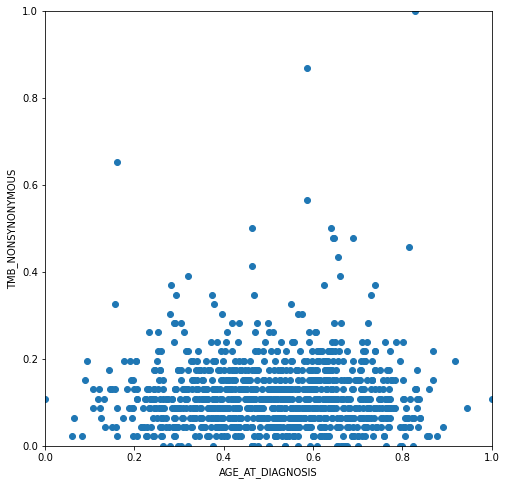

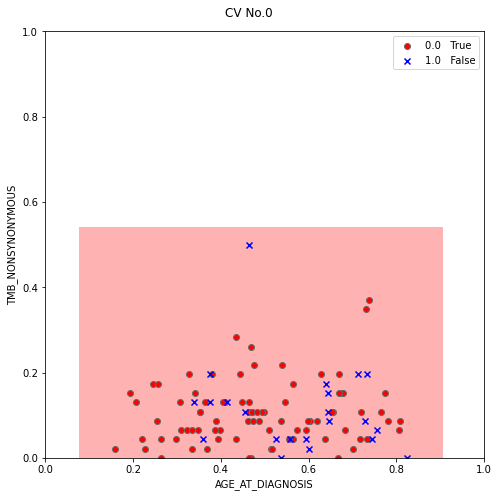

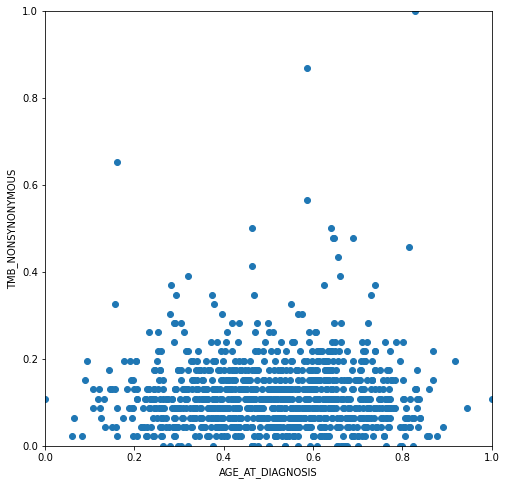

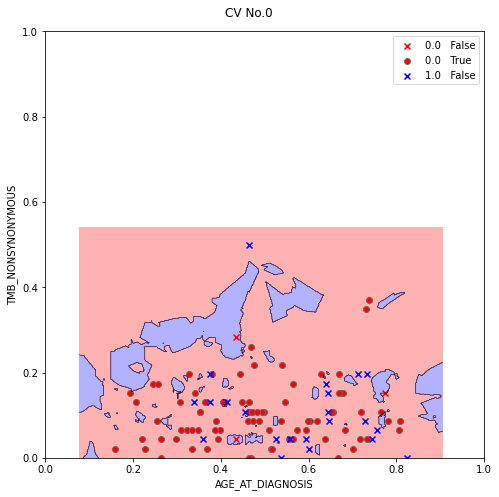

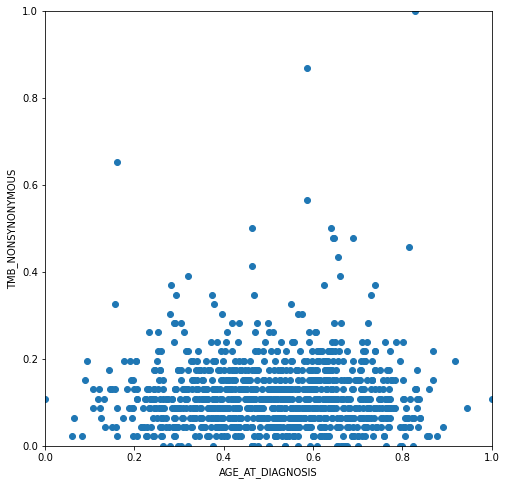

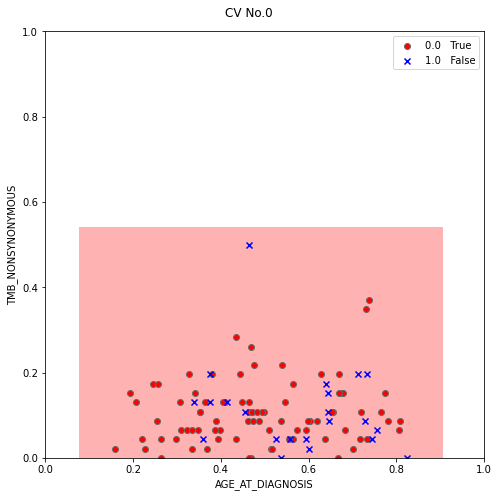

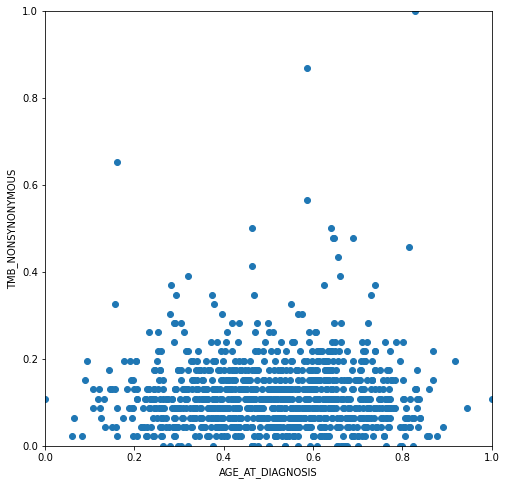

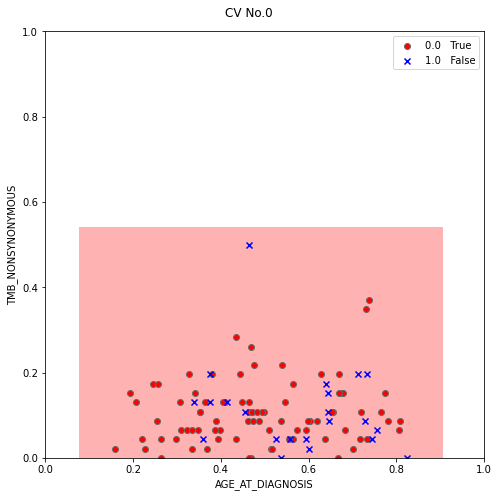

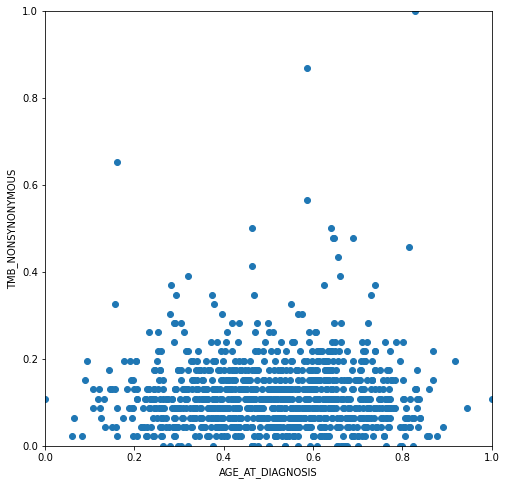

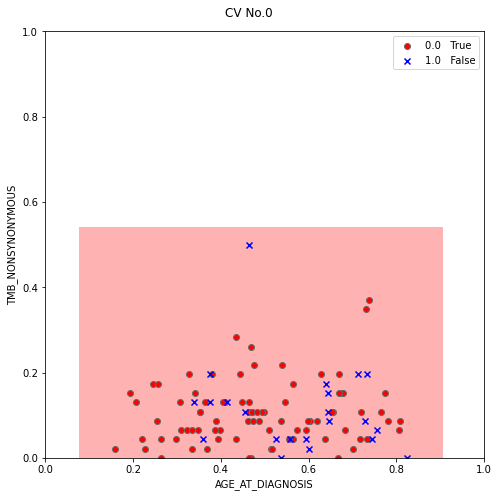

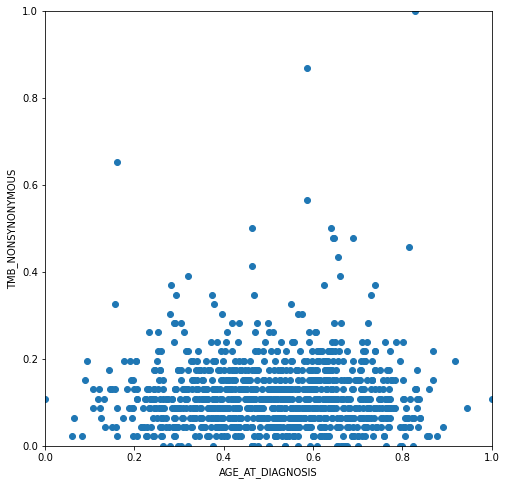

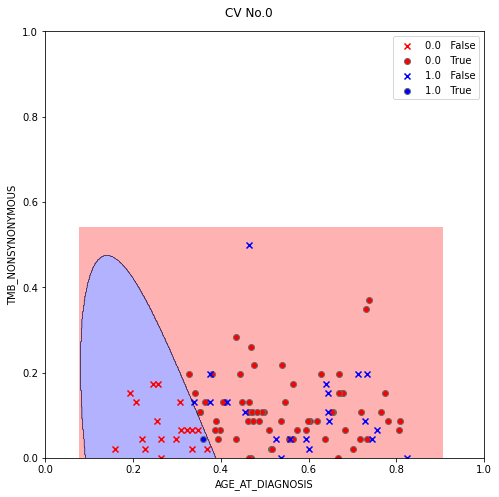

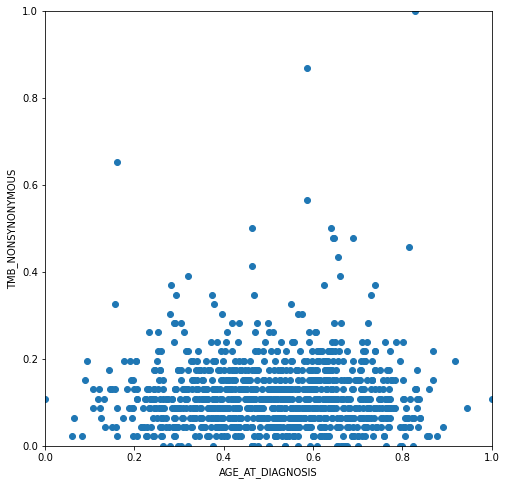

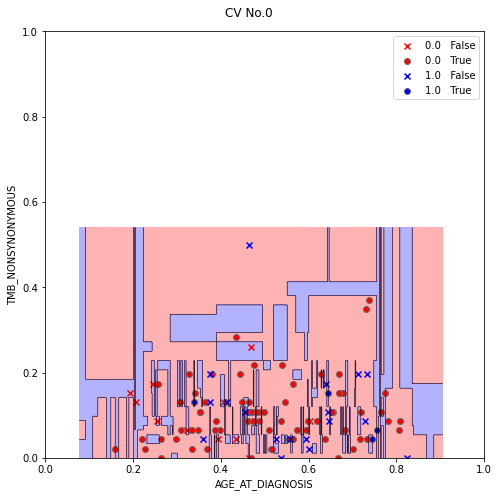

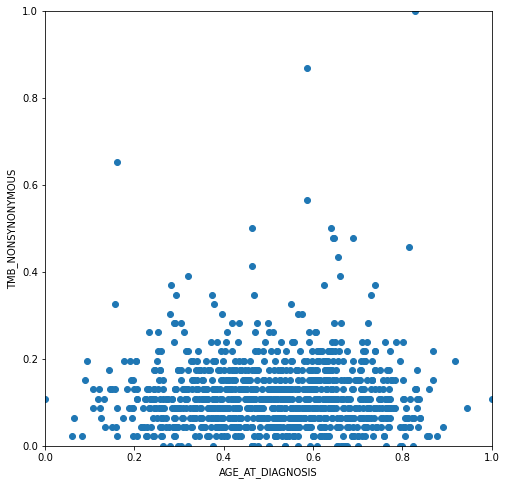

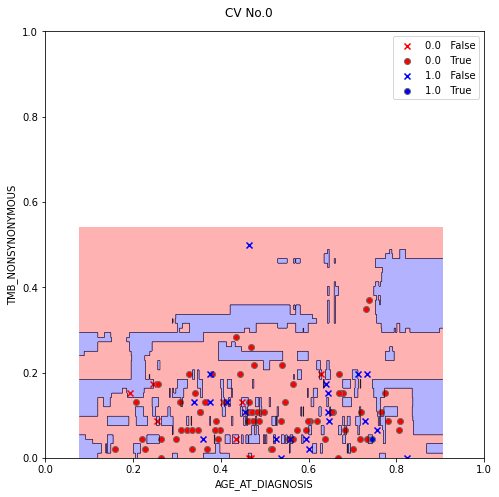

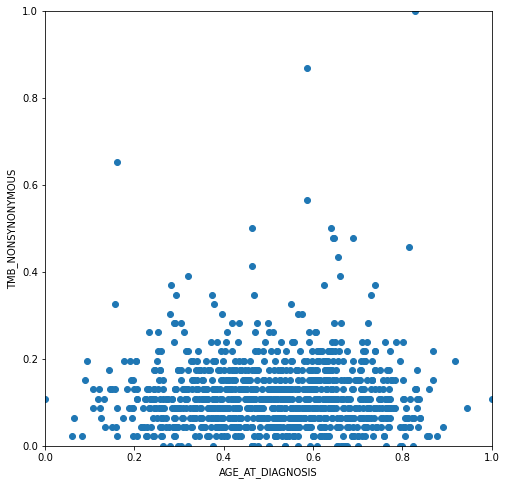

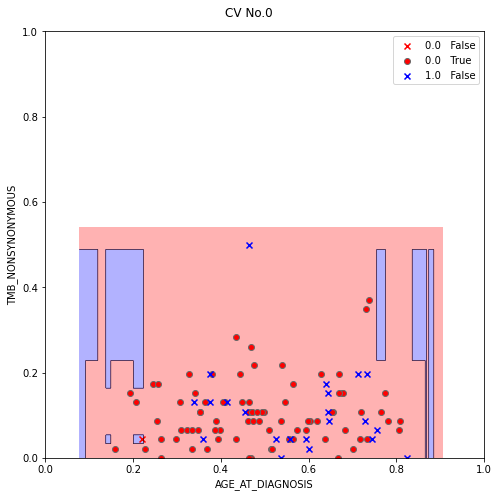

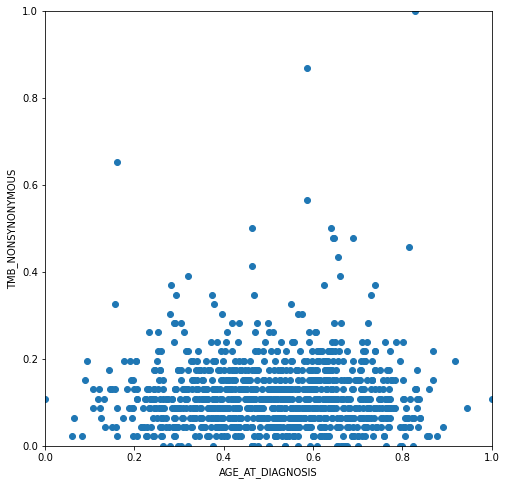

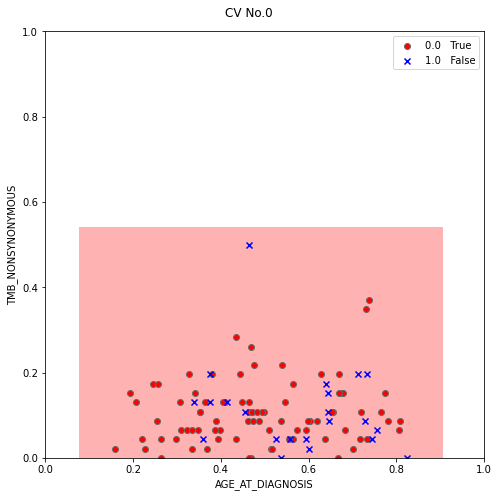

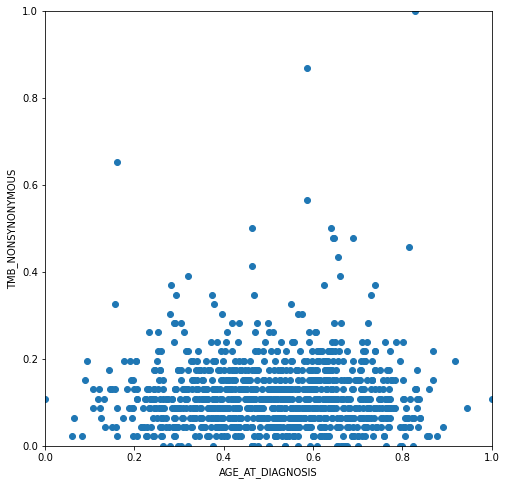

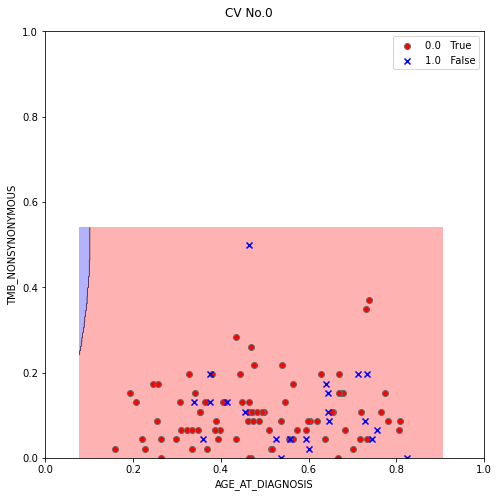

In [22]:
# plot側の内部処理でk分割交差検証を実施するので、trainとtestを結合したデータを渡す。
# ※各モデルのなんとなくの分類結果を見たい。どちらにせよ説明変数2つしか使わないので。
plot_bcm_border(X=X, y=y)

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [25]:
"""import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(
        max_leaf_nodes=nodes_num, random_state=config.SEED
    )
    clf_tree = clf_tree.fit(X_resampled, y_resampled)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    print("nodes_num: ", nodes_num)
    show_scores(y_test, y_pred_tree)
    print("----------" * 10)

warnings.filterwarnings("always")"""

'import warnings\n\nwarnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示\n\naccuracies_tree = {}\nprecisions_tree = {}\nrecalls_tree = {}\nf1_scores_tree = {}\n\nfor nodes_num in range(2, 50):\n    clf_tree = DecisionTreeClassifier(\n        max_leaf_nodes=nodes_num, random_state=config.SEED\n    )\n    clf_tree = clf_tree.fit(X_resampled, y_resampled)\n\n    y_pred_tree = clf_tree.predict(X_test)\n\n    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)\n    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)\n    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)\n    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)\n\n    print("nodes_num: ", nodes_num)\n    show_scores(y_test, y_pred_tree)\n    print("----------" * 10)\n\nwarnings.filterwarnings("always")'

In [26]:
# compare_bcms()

In [27]:
"""# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルのスコア
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)"""

'# 各スコアのプロット\ndisplay(\n    "max nodes_num",\n    max(accuracies_tree, key=accuracies_tree.get),\n    max(precisions_tree, key=precisions_tree.get),\n    max(recalls_tree, key=recalls_tree.get),\n    max(f1_scores_tree, key=f1_scores_tree.get),\n)\n\n# f1_scoreが最も高いモデルのスコア\nprint(\n    "accuracy: ",\n    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\nprint(\n    "precision: ",\n    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\nprint(\n    "recall: ",\n    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\nprint(\n    "f1_score: ",\n    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\n\ndf_score_tree = pd.DataFrame(\n    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],\n    index=["accuracy", "precision", "recall", "f1 score"],\n    columns=accuracies_tree.keys(),\n).T\np = sns.lineplot(data=df_score_tree)\np.set_xlabel("nodes_nums", fontsize=20)\np.set_ylabel("score", fontsize=20)'

In [28]:
'''clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_resampled, y_resampled)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)'''

'clf_tree = DecisionTreeClassifier(\n    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),\n    random_state=config.SEED,\n)\nclf_tree = clf_tree.fit(X_resampled, y_resampled)\ny_pred_tree = clf_tree.predict(X_test)\nshow_confusion_matrix(y_test, y_pred_tree)'